In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

from bayesopt.bayesopt import optimize_var_ND
from nn_integration.nni import integrate_ND_1L

## Define function and its gradient. Function will then be restored from its gradient

In [50]:
def func(x,y):
    assert x.shape == y.shape, "Inputs don't have the same shape"
    return np.cos(2*x + y)

def grad_func(x,y,noise):
    assert x.shape == y.shape, "Inputs don't have the same shape"
    return np.array([-2*np.sin(2*x + y), -np.sin(2*x + y)]) + noise*np.random.randn(*x.shape)

## Parameters to play with

In [51]:
X1_bounds = np.array([[0.0], [np.pi/2]])
X2_bounds = np.array([[0.0], [np.pi/2]])

noise = 0.1

num_init_points = 4
num_gridpoints = 101

# ----- BayesOpt parameters ----- #
kernel = RBF()
# kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
num_restarts = 50
max_iterations = 20
max_std_err = 1e-3

# ----- NN parameters ----- #
activation_function = "tanh"
solver = "lbfgs"
layer_size = 100
training_set_size = 2500
max_iter = 200

In [52]:
X1_grid = np.linspace(X1_bounds[0],X1_bounds[1],num_gridpoints).reshape(-1)
X2_grid = np.linspace(X2_bounds[0],X2_bounds[1],num_gridpoints).reshape(-1)
grid = np.zeros((len(X1_grid),len(X2_grid),2))
for i,x1 in enumerate(X1_grid):
    for j,x2 in enumerate(X2_grid):
        grid[i,j] = np.array([x1,x2])

## Use Bayesian Optimization to learn the gradient function from a few noisy points

In [53]:
X1_init = np.random.uniform(X1_bounds[0],X1_bounds[1],num_init_points)
X2_init = np.random.uniform(X1_bounds[0],X1_bounds[1],num_init_points)
Y_init = grad_func(X1_init,X2_init,noise).T
X_init = np.vstack(([X1_init],[X2_init])).T

In [54]:
gpr = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=num_restarts,alpha=noise**2)

In [55]:
means_iter, stds_iter = optimize_var_ND(X_init,Y_init,gpr,grad_func,grid.reshape(-1,2),max_iters=max_iterations,rel_std_noise=max_std_err)

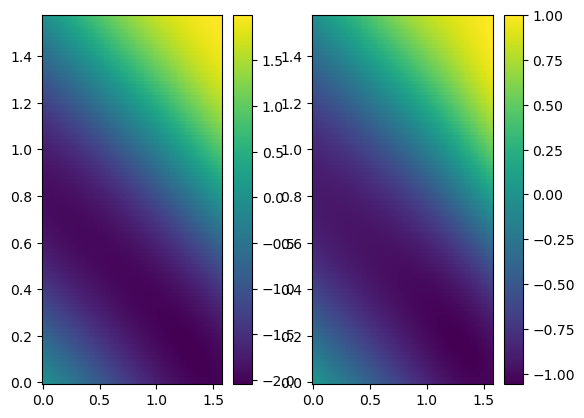

In [56]:
means = np.array(means_iter[-1]).reshape(num_gridpoints,num_gridpoints,2)

f,ax = plt.subplots(1,2)
plt1 = ax[0].pcolormesh(X1_grid,X2_grid,means[:,:,0])
plt2 = ax[1].pcolormesh(X1_grid,X2_grid,means[:,:,1])
plt.colorbar(plt1,ax=ax[0])
plt.colorbar(plt2,ax=ax[1])

## Training the Neural Network on the output of the BayesOpt

In [57]:
model = MLPRegressor((layer_size,),activation=activation_function,solver=solver,max_iter=max_iter)

In [58]:
rng = np.random.default_rng()
dataset = np.concatenate((grid.reshape(-1,2),means_iter[-1]),axis=1)
training_data = rng.permutation(dataset,axis=0)[:training_set_size]

In [59]:
model.fit(training_data[:,:2],training_data[:,2:])

d:\anaconda3\envs\bayesopt\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(activation='tanh', solver='lbfgs')

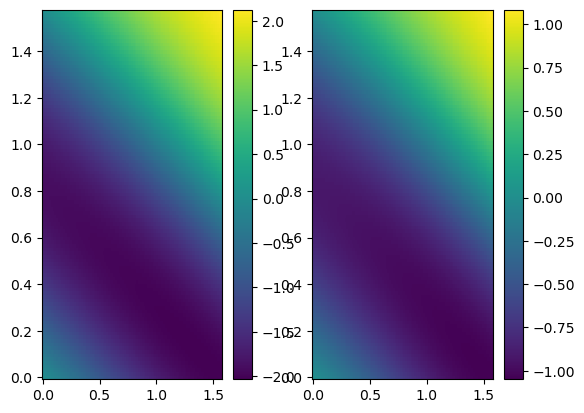

In [60]:
prediction = model.predict(grid.reshape(-1,2)).reshape(num_gridpoints,num_gridpoints,2)

f,ax = plt.subplots(1,2)
plt1 = ax[0].pcolormesh(X1_grid,X2_grid,prediction[:,:,0])
plt2 = ax[1].pcolormesh(X1_grid,X2_grid,prediction[:,:,1])
plt.colorbar(plt1,ax=ax[0])
plt.colorbar(plt2,ax=ax[1])

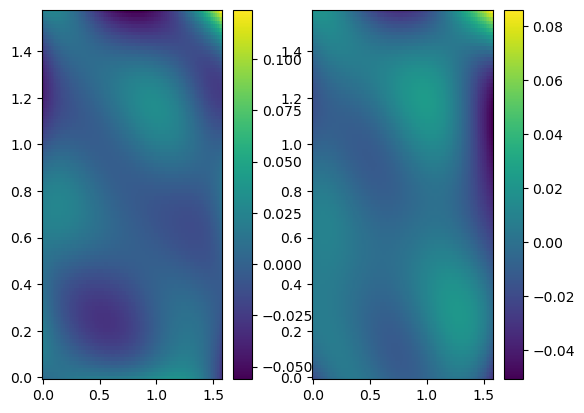

In [61]:
f,ax = plt.subplots(1,2)
plt1 = ax[0].pcolormesh(X1_grid,X2_grid,prediction[:,:,0]-means[:,:,0])
plt2 = ax[1].pcolormesh(X1_grid,X2_grid,prediction[:,:,1]-means[:,:,1])
plt.colorbar(plt1,ax=ax[0])
plt.colorbar(plt2,ax=ax[1])

## Integrating the Network to restore the original function

In [62]:
bounds = np.array([[0,0],[np.pi/2,np.pi/2]])

integral = integrate_ND_1L(bounds,model.coefs_,model.intercepts_,activation_function)
print(integral)

-0.9398148732829932


In [63]:
# Diagonal integral only works when grid is square
integral_diag = np.zeros_like(X1_grid)
integral_x1 = np.zeros_like(X1_grid)
integral_x2 = np.zeros_like(X2_grid)

for i,x in enumerate(X1_grid[1:]):
    bounds_diag = np.array([[0,0],[x,x]])
    bounds_x1 = np.array([[0,0],[x,0]])
    integral_diag[i+1] = integrate_ND_1L(bounds_diag,model.coefs_,model.intercepts_,activation_function)
    integral_x1[i+1] = integrate_ND_1L(bounds_x1,model.coefs_,model.intercepts_,activation_function)

    
for i,x in enumerate(X1_grid[1:]):
    bounds_x2 = np.array([[0,0],[0,x]])
    integral_x2[i+1] = integrate_ND_1L(bounds_x2,model.coefs_,model.intercepts_,activation_function)

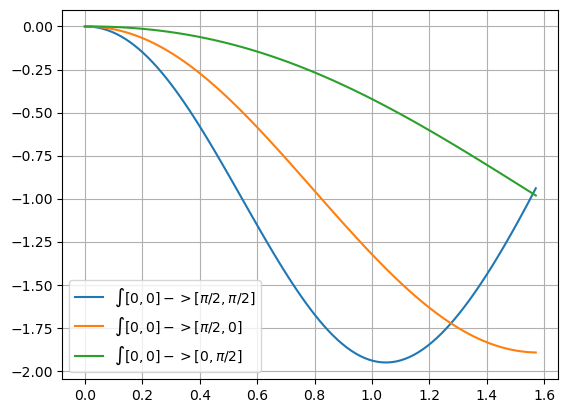

In [64]:
plt.plot(X1_grid,integral_diag,label="$\int[0,0]->[\pi/2,\pi/2]$")
plt.plot(X1_grid,integral_x1,label="$\int[0,0]->[\pi/2,0]$")
plt.plot(X2_grid,integral_x2,label="$\int[0,0]->[0,\pi/2]$")
plt.legend()
plt.grid()